In [79]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, hstack, vstack
import matplotlib.pyplot as plt 
import numpy as np
from astroML.stats import binned_statistic_2d
%matplotlib inline

# Crossmatch HLC and NSC with Gaia

In [19]:
#------------------------HLC-----------------------#

hlc1=Table.read('HLC.RA_00_to_01.fits.gz')
hlc2=Table.read('HLC.RA_01_to_02.fits.gz')
hlc3=Table.read('HLC.RA_02_to_03.fits.gz')
hlc4=Table.read('HLC.RA_03_to_04.fits.gz')
hlc5=Table.read('HLC.RA_20_to_21.fits.gz')
hlc6=Table.read('HLC.RA_21_to_22.fits.gz')
hlc7=Table.read('HLC.RA_22_to_23.fits.gz')
hlc8=Table.read('HLC.RA_23_to_24.fits.gz')

table1=vstack(hlc1,hlc2,hlc3)
table2=vstack(table1,hlc4,hlc5)
table3=vstack(table2,hlc6,hlc7)
hlc=vstack(table3,hlc8)

#------------------------NSC------------------------#

nsc1=Table.read('stripe82_315_ra_45_-1_3_dec_0.csv', format='ascii', data_end=499999)
nsc2=Table.read('stripe82_315_ra_45_-1_3_dec_0.csv', format='ascii', data_start=500000, data_end=999999)
nsc3=Table.read('stripe82_315_ra_45_-1_3_dec_0.csv', format='ascii', data_start=1000000)
nsc4=Table.read('stripe82_315_ra_45_0_dec_1_3.csv', format='ascii', data_end=499999)
nsc5=Table.read('stripe82_315_ra_45_0_dec_1_3.csv', format='ascii', data_start=500000, data_end=999999)
nsc6=Table.read('stripe82_315_ra_45_0_dec_1_3.csv', format='ascii', data_start=1000000)

table4=vstack(nsc1,nsc2,nsc3)
table5=vstack(table4,nsc4,nsc5)
nsc=vstack(table5,nsc6)


#------------------------Gaia-----------------------#
colnames = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr']
gaia     = Table.read('Stripe82_GaiaDR1.dat.gz', format='ascii', names=colnames)

#------------------Read RA and DEC------------------#

hlcra   = hlc['RA_MEAN']
hlcdec  = hlc['DEC_MEAN']
nscra   = nsc['ra']
nscdec  = nsc['dec']
gaiara  = gaia['ra']
gaiadec = gaia['dec']

#----------------Create coodinates------------------#

HLCcoords = SkyCoord(ra = hlcra*u.degree, dec= hlcdec*u.degree) 
GAIAcoords = SkyCoord(ra = gaiara*u.degree, dec= gaiadec*u.degree)
NSCcoords = SkyCoord(ra = nscra*u.degree, dec= nscdec*u.degree)

#-----------------Match HLC and Gaia---------------#

hidx, hd2d, hd3d = GAIAcoords.match_to_catalog_sky(HLCcoords)
nidx, nd2d, nd3d = GAIAcoords.match_to_catalog_sky(NSCcoords)

#----------------New HLC and NSC tables-------------#

hlc=hlc[hidx]
nsc=nsc[nidx]

### Other defined columns

In [38]:
hlc_gmag=hlc['MEAN_PSFMAG_CLIP'][:,1]
nsc_gmag=nsc['gmag']
gaia_gmag=gaia['Gmag']

# G Magnitude Histogram

We only have g-band for GAIA, so I plotted its magnitude istograms for all three catalogues.

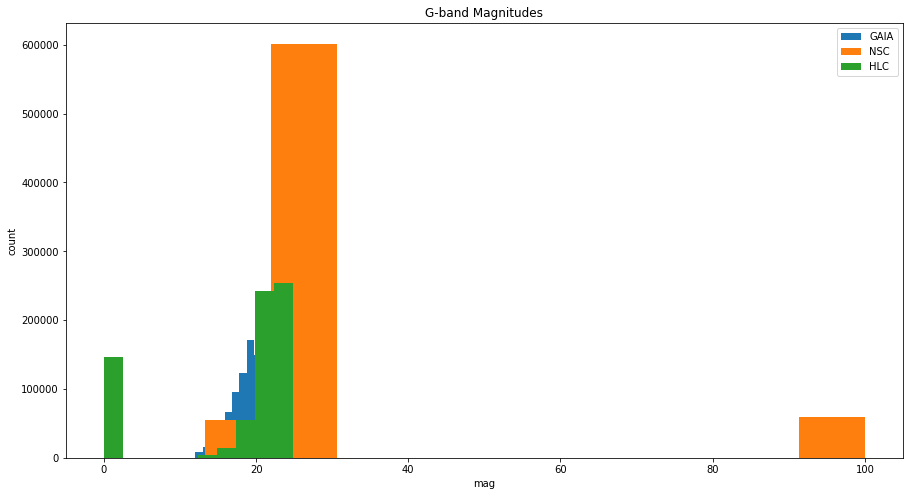

In [51]:
fig = plt.figure(figsize=[15,8])
plt.title('G-band Magnitudes')
plt.xlabel('mag')
plt.ylabel('count')
x,bins,a=plt.hist(gaia_gmag, label='GAIA')
plt.hist(nsc_gmag, label='NSC')
plt.hist(hlc_gmag, label='HLC')
plt.legend()
plt.show()

I need to filter the zeros--don't think they belong.

In [47]:
#--------------g-band filters---------------------#

hgclip=hlc_gmag != 0

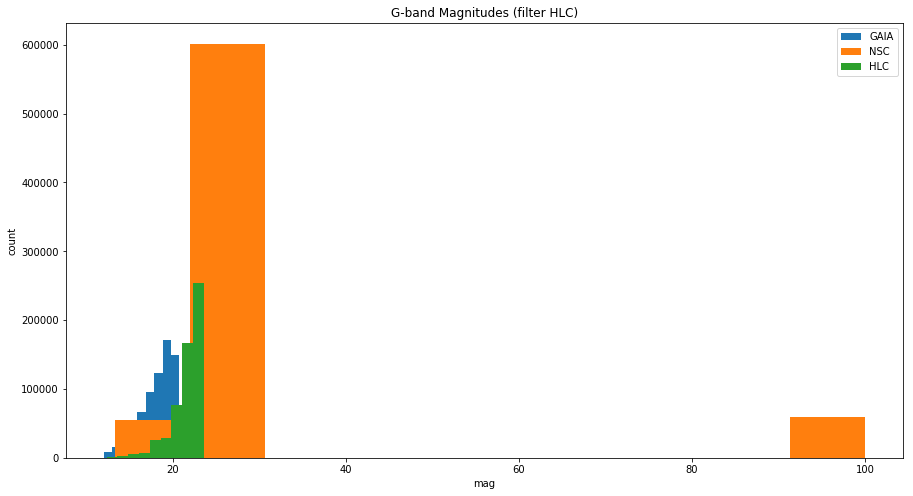

In [52]:
fig = plt.figure(figsize=[15,8])
plt.title('G-band Magnitudes (filter HLC)')
plt.xlabel('mag')
plt.ylabel('count')
x,bins,a=plt.hist(gaia_gmag, label='GAIA')
plt.hist(nsc_gmag, label='NSC')
plt.hist(hlc_gmag[hgclip], label='HLC')
plt.legend()
plt.show()

/astro/users/bt717/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


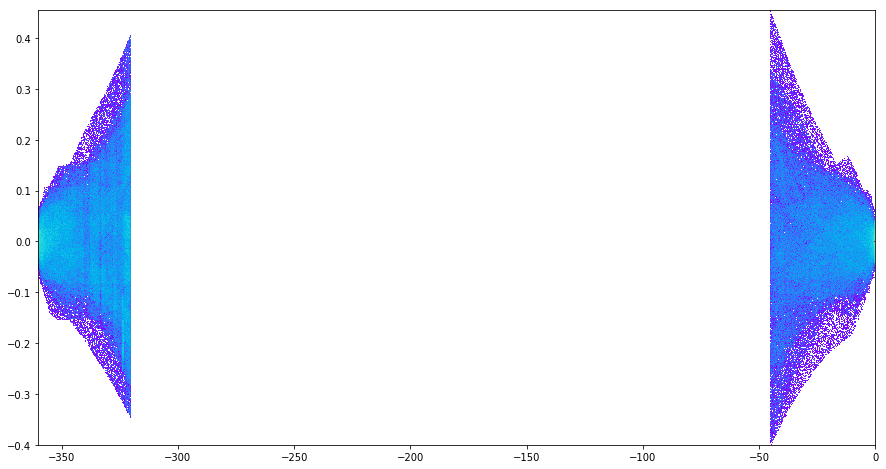

In [81]:
#--------dRA dDEC HLC and GAIA------------#

drah=hlcra-gaiara
ddech=hlcdec-gaiadec

#---bin size---#
xbins=np.sqrt(len(drah))
ybins=np.sqrt(len(ddech))

N, xedges, yedges = binned_statistic_2d(drah, ddech, drah, 'count', bins=[xbins,ybins])

multicolor = plt.cm.rainbow

fig = plt.figure(figsize=[15,8])
plt.imshow(np.log10(N.T), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], 
        yedges[-1]], aspect='auto', interpolation='nearest', cmap=multicolor)